In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
dict_dfs_fs = pd.read_pickle('data_fs.pkl')
print(dict_dfs_fs.keys())

dict_keys(['target', 'features', 'others', 'features_pre', 'features_sel', 'vt', 'vt_result'])


### Train, Test set

In [4]:
# train, test
X_train = dict_dfs_fs['features_sel'][dict_dfs_fs['others']['Group'] == 'train']
X_test = dict_dfs_fs['features_sel'][dict_dfs_fs['others']['Group'] == 'test']
y_train = dict_dfs_fs['target'][dict_dfs_fs['others']['Group'] == 'train']
y_test = dict_dfs_fs['target'][dict_dfs_fs['others']['Group'] == 'test']

### Imbalanced

In [3]:
from imblearn.over_sampling import SMOTENC

In [ ]:
cols_num = ['資本額', '餐飲業次業別數', '標章分數', '場所規模']
cols_cat = list(X_train.drop(labels=cols_num, axis=1).columns)

# 測試
X_train['餐飲業次業別數'].astype('Float64')    
# 若原始數值欄位為 int ， SMOTENC 生成新樣本，該欄計算結果仍為整數

sm = SMOTENC(categorical_features=cols_cat, sampling_strategy=3/7, random_state=423)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [26]:
print(y_res.iloc[:5859, ].sum())
print(y_res.iloc[5859:, ].sum())
print(X_res['餐飲業次業別數'].dtype)
'餐飲業次業別數' in cols_cat

31
2466
Float64


False

### Model Fitting: Logistic Regression (with L1 penalty) 

In [4]:
lgs = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, random_state=422)
lgs.fit(X=X_train, y=y_train)

LogisticRegression(penalty='l1', random_state=422, solver='liblinear')

### Evaluation

In [5]:
# 預測機率
nda_PredProb = lgs.predict_proba(X=X_test)[:, 1]

In [6]:
# 違規案件預測結果排序
df_rsl = pd.DataFrame(
    {'真實值': y_test, '預測機率': nda_PredProb.round(4)}
)

i = 0
for id, real, prob in df_rsl.sort_values(by='預測機率', ascending=False).itertuples(): 
    i += 1
    if real: 
        print(f'第{id}筆資料為{real}，機率為{prob}，排序在第{i}位')


第6748筆資料為1，機率為0.0187，排序在第32位
第6644筆資料為1，機率為0.0075，排序在第144位
第6499筆資料為1，機率為0.0039，排序在第300位
第6450筆資料為1，機率為0.0021，排序在第662位
第6547筆資料為1，機率為0.0013，排序在第872位
第5954筆資料為1，機率為0.001，排序在第957位


In [7]:
# 採用特徵
X_train.columns[lgs.coef_.flatten() > 0]

Index(['營業縣市_台東縣', '營業縣市_宜蘭縣', '營業縣市_新竹市', '營業縣市_桃園市', '營業縣市_高雄市', '場所型式_c',
       '是否兼具製造業', '投保責任險'],
      dtype='object')

* ROC

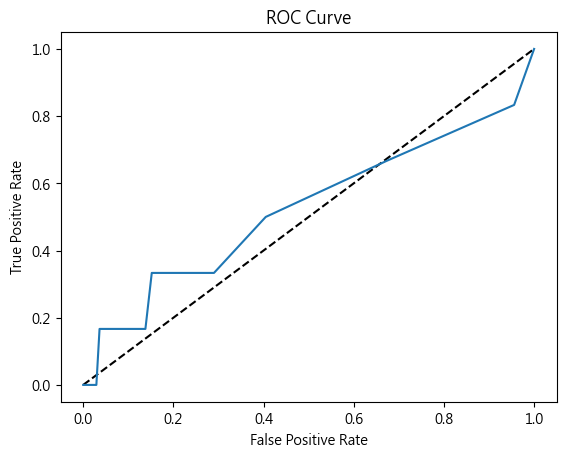

In [ ]:
ntp = np.array([((df_rsl['預測機率'] > thr) & (df_rsl['真實值'] == 1)).sum() for thr in np.linspace(1, 0, 1001)])
rtp = ntp / df_rsl['真實值'].sum()

nfp = np.array([((df_rsl['預測機率'] > thr) & (df_rsl['真實值'] == 0)).sum() for thr in np.linspace(1, 0, 1001)])
rfp = nfp / (df_rsl['真實值'] == 0).sum()

plt.plot(np.linspace(0, 1, 3), np.linspace(0, 1, 3), 'k--')
plt.plot(rfp, rtp)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.show()

* Confusion Matrix

In [ ]:
# 設定閾值為預測機率排序前 200 名
df_rsl['預測排序'] = df_rsl['預測機率'].rank(method='min', ascending=False).astype('uint16')
df_rsl['預測結果_by排序'] = (df_rsl['預測排序'] <= 200).astype('uint8')    # Pandas Vectorization

In [17]:
# 建立混淆矩陣
tp = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fp = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fn = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 0)].shape[0]
tn = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 0)].shape[0]

# 橫軸 Actual，縱軸 Predicted，左上 True Positive
nda_cm = np.array([[tp, fp], [fn, tn]])
nda_cm

array([[  2, 201],
       [  4, 792]])

In [18]:
# Evaluation Metrics
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2 / ((1/precision) + (1/recall))

print(f'precision: {precision: .4f} \nrecall: {recall: .4f} \nf1-score: {f1: .4f}')

precision:  0.0099 
recall:  0.3333 
f1-score:  0.0191


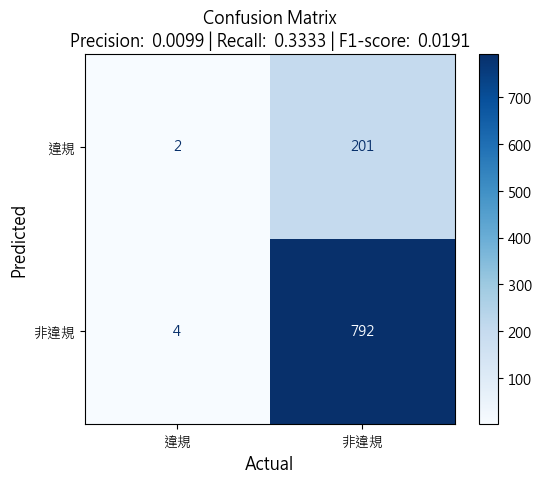

In [ ]:
# 繪製混淆矩陣
cm_labels = np.array(['違規', '非違規'])
disp = ConfusionMatrixDisplay(nda_cm, display_labels=cm_labels)

# 設定中文字型（整體）
plt.rcParams['font.family'] = 'Microsoft JhengHei'

# 設定顏色
disp.plot(cmap='Blues')

# 設定軸標題
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)

# 設定標題
score_string = f'Precision: {precision: .4f} | Recall: {recall: .4f} | F1-score: {f1: .4f}'
plt.title('Confusion Matrix\n' + score_string)

plt.show()